In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain.chat_models import init_chat_model

model = init_chat_model(
    "gpt-4o-mini",
    temperature=0.5
)

In [3]:
from typing_extensions import TypedDict

class WriterState(TypedDict):
    draft : str # Güncel tweet
    critique : str # Editor yorumu
    revision_number : int # Tweet sayısı


In [4]:
from langchain.messages import SystemMessage, HumanMessage

def writer_node(state: WriterState) -> WriterState:
    """Write a tweet about the article."""
    print("\n\n====================== Writer node called ======================")
    draft = state["draft"]
    critique = state.get("critique", "")

    if critique:
        prompt = f"You are a writer. Update an existing tweet based on the criticism. Criticism: {critique}"
    else:
        prompt = "You are a writer. Write a short but impactful tweet on the topic."


    messages = [
        SystemMessage(content=prompt),
        HumanMessage(content=draft),
    ]
    
    response = model.invoke(messages)
    print(f"Draft: {response.content}")

    return {"draft": response.content}    

In [5]:
def editor_node(state: WriterState) -> WriterState:
    """Critique the article."""
    print(f"\n\n====================== Editor node called: {state.get('revision_number', 0) + 1} ======================")
    messages = [
        SystemMessage(content="""
Review the following tweet draft.
Rules: It must be less than 280 characters, contain no emojis or hashtags, and be clear and effective. 
If the tweet is good enough, just write “YES” to approve it; do not comment. If it is not good enough, explain why it needs to be corrected.
        """),
        HumanMessage(content=state["draft"]),
    ]

    response = model.invoke(messages)
    print(f"Critique: {response.content}")

    
    return {"critique": response.content, "revision_number": state.get("revision_number", 0) + 1}

In [6]:
from typing import Literal
from langgraph.graph import StateGraph, START, END

def approve(state: WriterState) -> Literal["writer_node", END]:
    """Approve the tweet."""
    if state.get("critique", "").lower().startswith("yes"):
        return END
    elif state["revision_number"] > 4:
        return END
    
    return "writer_node"        

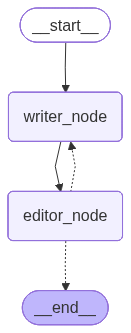

In [7]:
agent_builder = StateGraph(WriterState)

agent_builder.add_node("writer_node", writer_node)
agent_builder.add_node("editor_node", editor_node)

agent_builder.add_edge(START, "writer_node")
agent_builder.add_edge("writer_node", "editor_node")
agent_builder.add_conditional_edges(
    "editor_node",
    approve,
    ["writer_node", END]
)

agent = agent_builder.compile()


from IPython.display import Image, display
# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [10]:
tweet1 = agent.invoke({"draft": "Atatürk'ü anmak için 10 kasım hakkında kısa bir tweet yaz."})



====================== Writer node called ======================
Draft: "10 Kasım, Gazi Mustafa Kemal Atatürk'ü anma günü. Onun vizyonu ve cesareti, çağdaş Türkiye'nin temellerini attı. Unutmayalım ki, her bir adımımızda onun idealleri yaşamaya devam ediyor. #Atatürk"


====================== Editor node called: 1 ======================
Critique: The tweet contains a hashtag, which does not comply with the rules. Please revise it to remove the hashtag.


====================== Writer node called ======================
Draft: "10 Kasım, Gazi Mustafa Kemal Atatürk'ü anma günü. Onun vizyonu ve cesareti, çağdaş Türkiye'nin temellerini attı. Unutmayalım ki, her bir adımımızda onun idealleri yaşamaya devam ediyor."


====================== Editor node called: 2 ======================
Critique: YES


In [95]:
tweet2 = agent.invoke({"draft": "Türkiye'nin geleceğinin şekillenmesinde en büyük görev gençlerin olduğunu belirten bir tweet yaz."})



====================== Writer node called ======================
Draft: "Türkiye'nin geleceği, gençlerin hayal gücünde şekilleniyor. Onların cesareti, vizyonu ve kararlılığıyla daha aydınlık yarınlar inşa edebiliriz. 🇹🇷 #GençlikGeleceğimiz"


====================== Editor node called: 1 ======================
Critique: The tweet needs to be corrected because it contains a hashtag and an emoji, which do not comply with the established rules. Please revise it to eliminate these elements while maintaining clarity and effectiveness.


====================== Writer node called ======================
Draft: "Türkiye'nin geleceği, gençlerin hayal gücünde şekilleniyor. Onların cesareti, vizyonu ve kararlılığıyla daha aydınlık yarınlar inşa edebiliriz."


====================== Editor node called: 2 ======================
Critique: YES
